In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [2]:
N_sim = 50

In [3]:
e_sigmas = [0., 0.001, 0.003, 0.01]
nodes = {}
nodes_ws = {}
len_ws = {}
for e in e_sigmas:
    nodes[e] = list(np.load('cdc2019/nodes_sd_%.3f.npy'%e))
    if e == 0.:
        nodes_ws[e] = np.load('cdc2019/nodes_ws_sd_%.3f.npy'%e)[1:]
        len_ws[e] = np.load('cdc2019/len_ws_sd_%.3f.npy'%e)[:-1]
    else:
        nodes_ws[e] = [n[1:] for n in np.load('cdc2019/nodes_ws_sd_%.3f.npy'%e)]
        len_ws[e] = [n[:-1] for n in np.load('cdc2019/len_ws_sd_%.3f.npy'%e)]

In [4]:
# remove infeasible trajecotories
for e in e_sigmas[1:]:
    nodes[e] = [n for n in nodes[e] if len(n) == N_sim]
    nodes_ws[e] = [n for n in nodes_ws[e] if len(n) == N_sim-1]
    len_ws[e] = [n for n in len_ws[e] if len(n) == N_sim-1]

nodes = list(np.load('cdc2019/nodes_0.003.npy')
nodes_ws = list(np.load('cdc2019/nodes_ws_0.003.npy')
len_ws = list(np.load('cdc2019/len_ws_0.003.npy')
errors = list(np.load('cdc2019/errors_0.003.npy')

In [5]:
def get_statistics(data, len_data):
    mins = []
    means = []
    maxs = []
    sds = []
    for t in range(len_data):
        n_t = [float(n[t]) for n in data]
        mins.append(min(n_t))
#         means.append(sum(n_t)/len(n_t))
        means.append(np.median(n_t))
        maxs.append(max(n_t))
    return mins, means, maxs

In [6]:
def plot_statistics(ax, data, t0=0, **kwargs):
    mins, means, maxs = get_statistics(data, N_sim-t0)
    ax.plot(range(t0,N_sim), mins, linestyle='--', **kwargs)
    ax.plot(range(t0,N_sim), means, **kwargs)
    ax.plot(range(t0,N_sim), maxs, linestyle='-.', **kwargs)
    ax.fill_between(range(t0,N_sim), mins, maxs, alpha=.1, **kwargs)

In [7]:
from decimal import Decimal

def fexp(number):
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1

def fman(number):
    return Decimal(number).scaleb(-fexp(number)).normalize()

<IPython.core.display.Javascript object>


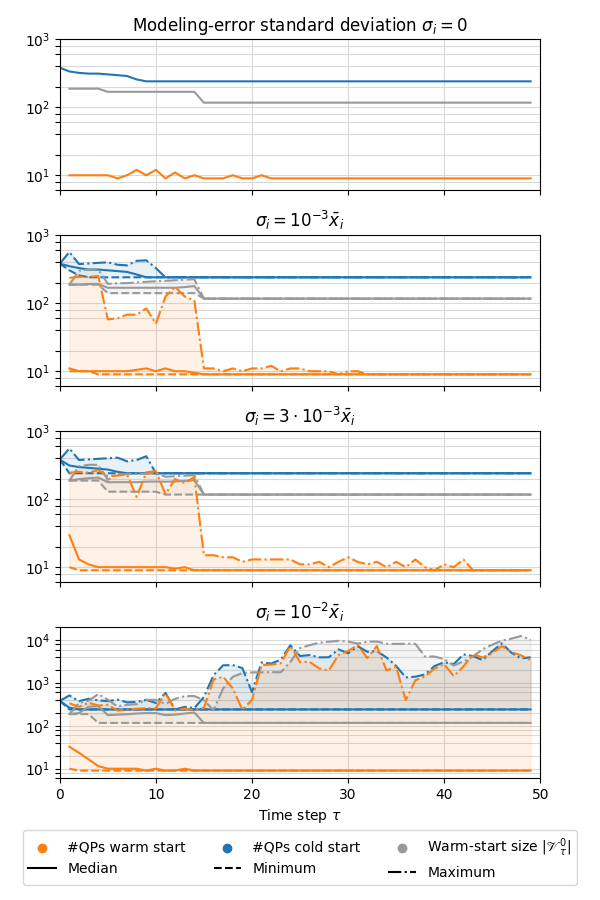

In [8]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.rcParams.update({'font.size': 10.5})

# start subplot
fig, axes = plt.subplots(len(e_sigmas), sharex=True, figsize=(6,9))

# nominal case
axes[0].plot(range(len(nodes[0.])), nodes[0.], color='#1f77b4')
axes[0].plot(range(1,len(len_ws[0.])+1), len_ws[0.], color=np.ones(3)*.6)#'#2ca02c')
axes[0].plot(range(1,len(nodes_ws[0.])+1), nodes_ws[0.], color='#ff7f0e')

for i, e in enumerate(e_sigmas[1:]):
    plot_statistics(axes[i+1], nodes[e], color='#1f77b4')
    plot_statistics(axes[i+1], len_ws[e], t0=1, color=np.ones(3)*.6)#'#2ca02c')
    plot_statistics(axes[i+1], nodes_ws[e], t0=1, color='#ff7f0e')
    
# set up
for i, ax in enumerate(axes):
    coef = float(fman(e_sigmas[i]))
    exp = fexp(e_sigmas[i])
    if coef == 0.:
        ax.set_title(r'Modeling-error standard deviation $\sigma_i = 0$')
    elif coef == 1.:
        ax.set_title(r'$\sigma_i = 10^{%.0f} \bar x_i$'%exp)
    else:
        ax.set_title(r'$\sigma_i = %.0f \cdot 10^{%.0f} \bar x_i$'%(coef,exp))
    ax.set_yscale('symlog')
    ax.set_yticks([0]+[2*i*j for i in range(1,6) for j in [1e0, 1e1, 1e2, 1e3, 1e4]])
    ax.grid(True, color=np.ones(3)*.85)
    ax.set_axisbelow(True)
axes[0].set_ylim(6, 1e3)
axes[1].set_ylim(6, 1e3)
axes[2].set_ylim(6, 1e3)
axes[3].set_ylim(6, 2e4)
    
# legend
axes[0].scatter(-10., -10., color='#ff7f0e', label='#QPs warm start')
axes[0].scatter(-10., -10., color='#1f77b4', label='#QPs cold start')
axes[0].scatter(-10., -10., color=np.ones(3)*.6, label=r'Warm-start size $|\mathscr{V}_{\tau}^0|$')#'#2ca02c')
axes[0].plot(-10., -10., color='k', label='Median')
axes[0].plot(-10., -10., color='k', linestyle='--', label='Minimum')
axes[0].plot(-10., -10., color='k', linestyle='-.', label='Maximum')

# log scale
handles, labels = axes[0].get_legend_handles_labels()
order = [3,0,4,1,5,2] # 3 columns
axes[-1].legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.3),
    ncol=3
)

# others
axes[-1].set_xlabel(r'Time step $\tau$')
plt.xlim(0, 50)
fig.tight_layout()
# plt.savefig('trends.pdf', bbox_inches='tight')